KMeans

referências: 
- https://www.youtube.com/watch?v=82JJCxyhIWU
- https://www.inf.ufpr.br/dagoncalves/IA06.pdf
- https://medium.com/pizzadedados/kmeans-e-metodo-do-cotovelo-94ded9fdf3a9
- https://ateliware.com/blog/classificacao-knn-k-means

Caracteristicas do algoritmo:

- Aprendizado não supervisionado (não conhecemos os labels)
- Baseado em centróides
- Simples e rápido

Roteiro:

- Importar as bibliotecas e o dataset Iris
- Definir o número ideal de clusters
- Desenvolvimento do algoritmo principal
- Comparação com o modelo do sklearn
- Comparação com o KNN

In [13]:
# imports
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [14]:
data = load_iris()
data['feature_names'], data['target_names']

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [15]:
X, y = data.data, data.target
X, y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [16]:
# Iremos trabalhar apenas com as duas ultimas caracteristicas do dataset
features_selected = data['feature_names'][2:]
X_selected = data.data[:, -2:]

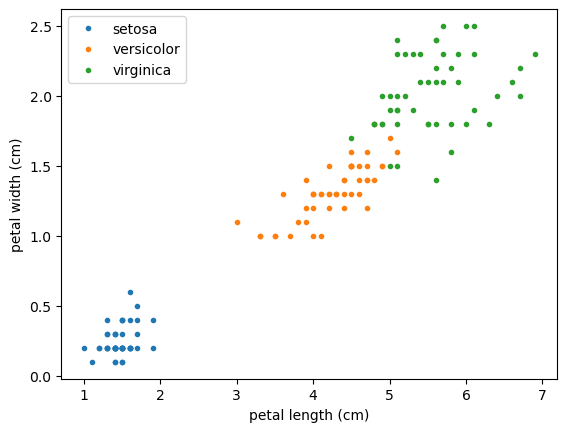

In [17]:
def plot_2d(X, y, centroids:dict=None, title=''):
    if X.shape[1] != 2:
        raise Exception("Apenas 2 features são permitidas.")

    for i in range(len(set(y))):
        plt.plot(X[y == i, 0], X[y == i, 1], '.', label=data.target_names[i])

    if centroids is not None:
        for centroid, center in centroids.items():
            plt.scatter(center.x, center.y, marker='s', s=100, label=f'C{centroid}:{np.round(center.x, 2), np.round(center.y, 2)}', c='red')

    plt.xlabel(data.feature_names[-2])
    plt.ylabel(data.feature_names[-1])
    plt.title(title)
    plt.legend()
    plt.show()

plot_2d(X_selected, y)

In [18]:
# abstrações

class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def euclidean_distance(self, point):
        if isinstance(point, Point):
            square = np.power(self.x - point.x, 2) + np.power(self.y - point.y, 2)
            return np.power(square, 0.5)
        else:
            raise TypeError("O parâmetro 'point' não é uma instância da classe Point.")
    
    def to_string(self):
        return f'({self.x, self.y})'

In [19]:
class K_Means():
    def __init__(self, n_clusters:int):
        self.n_clusters = n_clusters
        self.centroids = None

    def random_centroids(self, X_train:np.ndarray):
        centroids = {}
        if X_train.shape[1] != 2:
            raise Exception("Apenas 2 features são permitidas.")
        
        min_x, max_x = np.min(X_train[:, 0]), np.max(X_train[:, 0])
        min_y, max_y = np.min(X_train[:, 1]), np.max(X_train[:, 1])

        for i in range(self.n_clusters):
            x = np.random.uniform(min_x, max_x)
            y = np.random.uniform(min_y, max_y)
            centroids[i] = Point(x, y)

        return centroids
    
    # selection sort
    def lower_centroid_distance(self, point:Point):
        centroid_index, lower_distance = -1, np.inf

        for index, centroid in self.centroids.items():
            distance = centroid.euclidean_distance(point)
            if distance < lower_distance:
                centroid_index = index
                lower_distance = distance
            
        return centroid_index, lower_distance

    def centroids_to_point_list(self):
        centroids = self.centroids.copy()
        for k, v in centroids.items():
            centroids[k] = [v]

        return centroids

    def fit(self, X_train:np.ndarray, y_train:np.ndarray, tolerance=1e-5, max_iterations=1000):
        self.centroids = self.random_centroids(X_train)
        centroids = self.centroids_to_point_list()

        convergence = False
        for steps in range(max_iterations):
            for i in X_train:
                point = Point(*i)
                index, distance = self.lower_centroid_distance(point)
                centroids[index].append(point)

            for k, v in centroids.items():
                mean_x = np.mean([point.x for point in v])
                mean_y = np.mean([point.y for point in v])
                new_centroid = Point(mean_x, mean_y)

                # validação de convergência
                if np.allclose([new_centroid.x, new_centroid.y], [self.centroids[k].x, self.centroids[k].y], atol=tolerance) and steps > int(5/100 * max_iterations): # controle sobre falsas convergências
                    convergence = True
                    break

                self.centroids[k] = new_centroid

            if convergence is True:
                print(f'Convergência alcançada com {steps} passos.')
                break

            # plot_2d(features_selected, y_train, self.centroids)
            
    def predict(self, X_test):
        if self.centroids is None:
            raise Exception("Os centróides ainda não foram calculados, por favor chame a função fit primeiro.")

        cluster_assignments = []
        for point in X_test:
            point = Point(*point)
            centroid_index, _ = self.lower_centroid_distance(point)
            cluster_assignments.append(centroid_index)

        return cluster_assignments

Convergência alcançada com 51 passos.


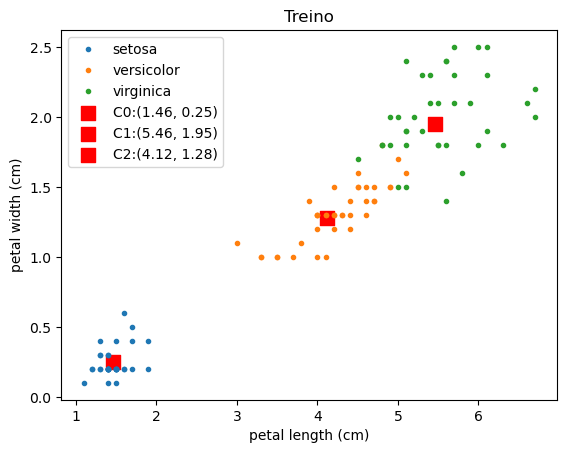

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=42)

model = K_Means(3)
model.fit(X_train.copy(), y_train)
plot_2d(X_train, y_train, model.centroids, 'Treino')

In [21]:
# avalidação, faz sentido?
ypred = model.predict(X_test)
score = accuracy_score(y_test, ypred)

score

0.39473684210526316

Benchmark com sklearn:

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

/home/lucas/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


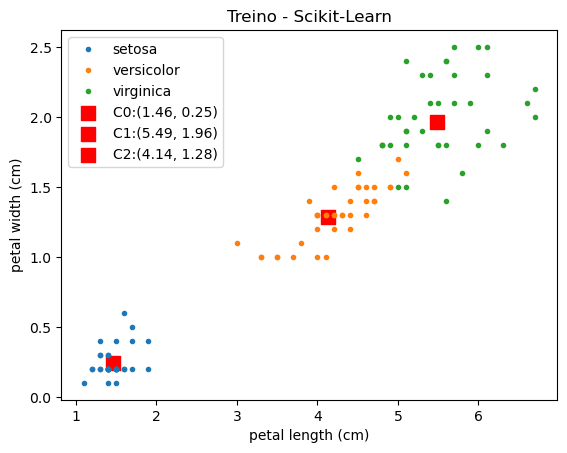

In [22]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(X_train, y_train)
predictions_sklearn = model.predict(X_test)

plot_2d(X_train[:, -2:], y_train, {i: Point(center[0], center[1]) for i, center in enumerate(model.cluster_centers_)}, 'Treino - Scikit-Learn')

In [23]:
ypred = model.predict(X_test)
score = accuracy_score(y_test, ypred)

score

0.39473684210526316

Comparando com KNN

In [24]:
model = KNeighborsClassifier(10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)

score

1.0